#### Validating the Fitbit Against Research Grade Accelerometers in a Free-Living Environment

This code compares physical activity data from research grade accelerometers (called Actigraphs) to the Fitbit, a popular physical activity tracker. The purpose is to see how well physial activity data from the Fitbit matches data from the Actigraph in a free-living environment. Both the Actigraph and the Fitbit track how many steps a user takes on a minute by minute basis, and these step counts will serve as the basis of comparison between the Fitbit and the Actigraph.

A cohort of 20 Fitbit users were recruited to wear both their Fitbit and an Actigraph accelerometer for 7 days. For each study participant, the number of steps recorded from each device are compared graphically and with Pearson's correlation coefficient. From the Actigraph data, minutes of moderate to vigorous physical activity (MVPA) are calculated for each participant, and a scatter plot visualizes the relationship between MVPA and the steps correlation coefficient for each user. The hypothesis is that perhaps the Fitbit matches the Actigraph best when users are more sedentary (i.e., have fewer minutes of MVPA).

In [2]:
import pandas as pd
import numpy as np
import os.path
import glob
import datetime
from scipy.stats import describe
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("ggplot")

Actigraph data are stored in separate .csv files for each participant. The following code loops through each participant file, cleaning the data and appending it to the total DataFrame. 

Date and time variables from the original .csv files are read in as dates (which is why this code takes a particularly long time to run). Date and time are combined into a single variable that is adjusted to the participant's time zone. The data are limited to the dates that the user participated in the study. Minutes of MVPA are defined using Freedson's cutpoint, which classifies MVPA as any movement with an activity count greater than 1951. Data by minutes is collapsed into data by hour, summing steps and MVPA. Columns are created to store ID and accelerometer information so that Actigraph data can later be linked to Fitbit data. 

In [3]:
# Creating a list of all Actigraph .csv files
accel_file = glob.glob("Accel CSV data/User*_ActigraphMay.csv")

# Creating a DataFrame that stores user time zone and date range information
dates = pd.read_csv("Dates.csv", index_col=0, parse_dates=['Initial', 'Final'])

# Defining a variable for the MVPA cutpoint
mvpa_cutpoint = 1951

# Creating an empty DataFrame to store individual DataFrames from the following loop
total = pd.DataFrame()

for file in accel_file:
    accel = pd.read_csv(file, skipinitialspace=True, parse_dates=[['Date','Time']]) 
    accel['Date_Time'] = accel['Date_Time'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, 0))
    
    # Storing the user_id from the filename
    user_id = int(os.path.basename(file).split("_")[0].replace('User',''))
    
    # Adjusting for time zone
    offset = int(dates.loc[user_id].Offset)
    accel['Date_Time'] += datetime.timedelta(hours=offset)
    
    # Limiting dates to the days of the study
    date_range = dates.loc[user_id]
    date_bool1 = np.array(accel.Date_Time > date_range.Initial)
    date_bool2 = np.array(accel.Date_Time < date_range.Final)
    wear_dates = np.logical_and(date_bool1, date_bool2)
    accel = accel[wear_dates]
    
    # Boolean variable classifying each minute as MVPA or not
    accel['MVPA'] = accel['Axis1'] > mvpa_cutpoint
    
    # Grouping by hour and finding out total steps and MVPA per hour
    by_hour = accel.groupby(['Date_Time'])
    hour_totals = by_hour.sum().reset_index()

    # Creating identification columns and appending the user DataFrame to the total DataFrame
    hour_totals['User'] = user_id
    hour_totals['Type'] = 'Actigraph'
    total = total.append(hour_totals, ignore_index=True)

accel_total = total[['User', 'Type', 'Date_Time', 'Steps', 'MVPA']]
accel_total.head()

,User,Type,Date_Time,Steps,MVPA
0,10311,Actigraph,2015-05-16 01:00:00,23,0
1,10311,Actigraph,2015-05-16 02:00:00,5,0
2,10311,Actigraph,2015-05-16 03:00:00,0,0
3,10311,Actigraph,2015-05-16 04:00:00,7,0
4,10311,Actigraph,2015-05-16 05:00:00,27,0


Summary statistics for each participant are calculated and stored in the user_stats DataFrame. The minimum, maximum and average daily steps are stored for each user, as well as total minutes of MVPA over the entire seven day period. 

In [4]:
# Creating a new DataFrame for Actigraph data and grouping by user and date
actigraph = pd.DataFrame()
actigraph = actigraph.append(accel_total)
actigraph['Date_Time'] = actigraph['Date_Time'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
daily = actigraph.groupby(['User', 'Date_Time'])['Steps','MVPA'].sum().reset_index()

# Creating empty series to store min, max and mean data for each user
min_steps = pd.Series()
max_steps = pd.Series()
mean_steps = pd.Series()

# Looping through each user to calculate min, max and mean hourly steps
for user, user_data in daily.groupby(['User']):  
    data1 = describe(user_data.Steps)
    minimum = data1[1][0]
    maximum = data1[1][1]
    mean = data1[2]

    min_steps = min_steps.append(pd.Series(minimum, index=[user]))
    max_steps = max_steps.append(pd.Series(maximum, index=[user]))
    mean_steps = mean_steps.append(pd.Series(mean, index=[user]))

# Creating a DataFrame to store summary statistics
user_stats = pd.DataFrame(min_steps)
user_stats.columns = ['Min Daily Steps']
user_stats['Max Daily Steps'] = max_steps
user_stats['Average Daily Steps'] = mean_steps

# Calculating total MVPA over the 7-day period
by_user = daily.groupby(['User'])
total_mvpa = by_user.sum()['MVPA']
total_mvpa = pd.DataFrame(total_mvpa)
user_stats['Total MVPA']=total_mvpa.MVPA

user_stats

,Min Daily Steps,Max Daily Steps,Average Daily Steps,Total MVPA
701,6649,11172,8587.571429,401
2130,3422,6699,5016.142857,208
7373,3596,9494,6238.428571,209
7685,85,12612,8032.625000,439
9412,6748,14734,10273.285714,632
10311,8087,14688,11171.285714,450
10467,4647,19234,10157.000000,252
10601,0,12695,7161.000000,206
10900,2598,8094,4586.857143,37
10921,2846,6596,3957.857143,40


From the summary statistics stored in the user_stats DataFrame, histograms are created to visualize the distribution of average daily steps and total MVPA for this cohort. 

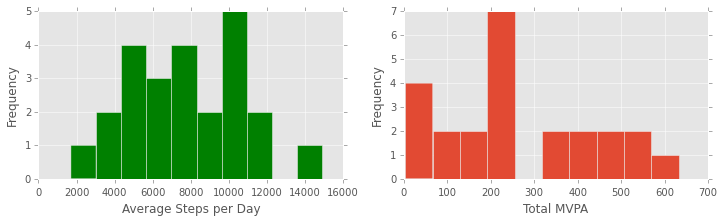

In [5]:
plt.figure(figsize=(12.0, 3.0))

plt.subplot(1, 2, 1)
plt.hist(user_stats['Average Daily Steps'].values, color='g')
plt.xlabel('Average Steps per Day')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(user_stats['Total MVPA'].values)
plt.xlabel('Total MVPA')
plt.ylabel('Frequency')
plt.show()

Fitbit data are stored in a master file that is read into the fitbit DataFrame. The date and minute variables are combined into Date_Time and all other variables are renamed to match the Actigraph data. Data are limited to the dates that the user participated in the study. Data is grouped by hour to match Actigraph data, and columns are created to identify the data by user and type.

In [6]:
# Reading in fitbit data and editing columns to match the Actigraph data
fitbit = pd.read_csv('meas_fitbit_intraday_1wk_4.txt', sep='|', parse_dates=['date'])
fitbit.rename(columns={'user_id':'User', 'date':'Date', 'steps':'Steps'}, inplace=True)
fitbit.sort(['User','Date','minute'], axis=0, inplace=True)
fitbit['Hour'] = (fitbit['minute'] / 60).astype(int) % 24
fitbit.loc[fitbit['minute']==1440, 'Date'] += datetime.timedelta(days=1)
fitbit['Date_Time'] = fitbit[['Date', 'Hour']].apply(lambda row: datetime.datetime(row.Date.year, row.Date.month, row.Date.day, row.Hour, 0), axis=1)

# Dropping dates outside of the date range for each user
fitbit = fitbit.join(dates, on='User')
date_bool1 = np.array(fitbit.Date_Time > fitbit.Initial)
date_bool2 = np.array(fitbit.Date_Time < fitbit.Final)
wear_dates = np.logical_and(date_bool1, date_bool2)
fitbit = fitbit[wear_dates]

# Grouping by hour
by_hour = fitbit.groupby(['User', 'Date_Time'])
hour_totals = by_hour.sum().reset_index()
hour_totals['Type'] = 'Fitbit'
fitbit_total = hour_totals[['User', 'Type', 'Date_Time', 'Steps']]

fitbit_total.head()

,User,Type,Date_Time,Steps
0,701,Fitbit,2015-05-18 01:00:00,0
1,701,Fitbit,2015-05-18 02:00:00,0
2,701,Fitbit,2015-05-18 03:00:00,0
3,701,Fitbit,2015-05-18 04:00:00,0
4,701,Fitbit,2015-05-18 05:00:00,608


A master DataFrame is created combining Actigraph and Fitbit data for all users into one DataFrame. Users who did not provide Fitbit data are dropped from analysis. 

In [7]:
# Combining accelerometer and fitbit DataFrames into a master DataFrame
master = pd.concat([accel_total, fitbit_total])
master.sort(['User','Date_Time','Type'], inplace=True)
master = master[['User', 'Type', 'Date_Time', 'Steps']]

# Dropping users who did not provide Fitbit data
by_user = master.groupby(['User'])
total_minutes = by_user.count()
users_to_drop = total_minutes[total_minutes['Type'] < 200].index
master = master[-master.User.isin(users_to_drop)]

master.head()

,User,Type,Date_Time,Steps
3388,701,Actigraph,2015-05-18 01:00:00,0
0,701,Fitbit,2015-05-18 01:00:00,0
3389,701,Actigraph,2015-05-18 02:00:00,0
1,701,Fitbit,2015-05-18 02:00:00,0
3390,701,Actigraph,2015-05-18 03:00:00,0


A line plot is created for each user to visualize how well the Fitbit step data matches the Actigraph step data. 

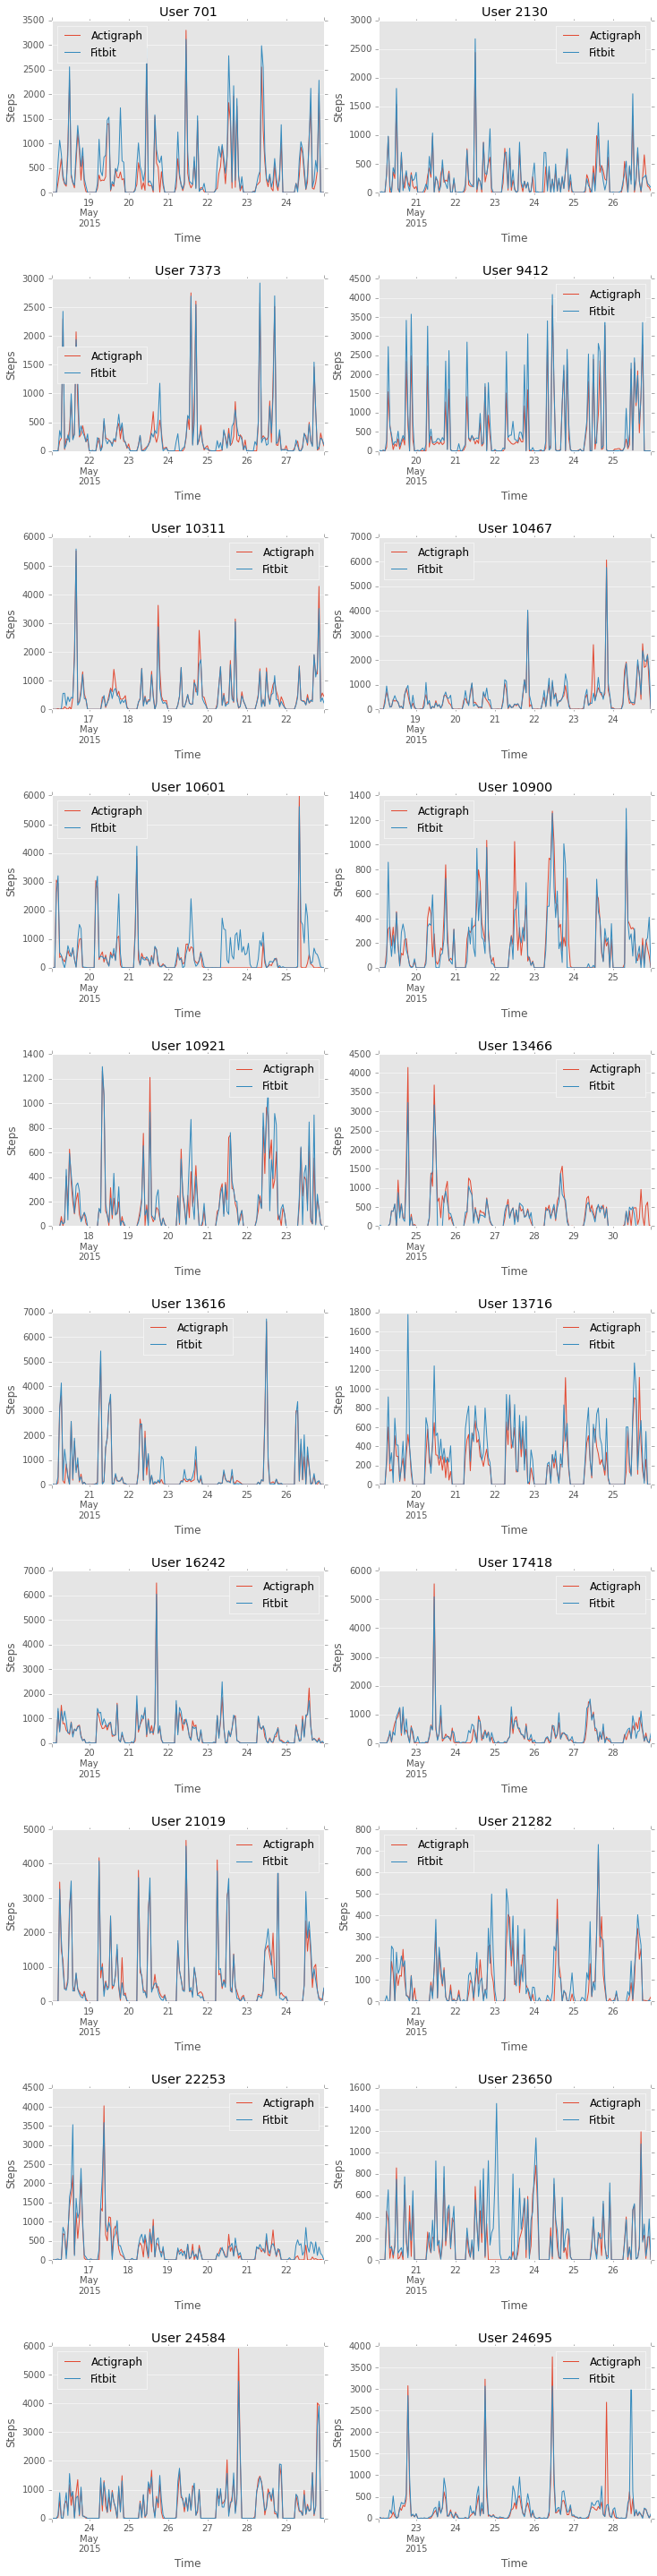

In [8]:
#fig = plt.figure()
#plt.figure(figsize=(10.0, 3.0))
fig, axs = plt.subplots(10, 2, figsize=(12, 50))
fig.subplots_adjust(hspace = .5)
i = 0
axs = axs.ravel()

for user, user_data in master.groupby(['User']):    
    axs[i] 
    labels = []
    for key, grp in user_data.groupby(['Type']):
        axs[i] = grp.plot(ax=axs[i], kind='line', x='Date_Time', y='Steps', c=key)
        labels.append(key)
    lines, _ = axs[i].get_legend_handles_labels()
    axs[i].legend(lines, labels, loc='best')
    axs[i].set_title('User ' + str(user))
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Steps')
    i += 1 

A Pearson's correlation coefficient is calculated for the Actigraph and Fitbit step data provided by each user. These coefficients are stored as a series.

In [9]:
correlation = pd.Series()

for user, user_data in master.groupby(['User']):  
    actigraph = np.array(user_data.Type == 'Actigraph')
    a = user_data[actigraph].Steps
    fitbit = np.array(user_data.Type == 'Fitbit')
    f = user_data[fitbit].Steps
      
    corr = np.corrcoef(a,f)[0,1]
    correlation = correlation.append(pd.Series(corr, index=[user]))

correlation.head()

701      0.950063
2130     0.937125
7373     0.974321
9412     0.959722
10311    0.974315
dtype: float64

Summary statistics are calculated and a histogram is created to visualize the distribution of correlation coefficients. From the histogram, it appears that the step data from the Actigraph and Fibit accelerometers are reasonably well correlated. The average correlation coefficient is above 0.91, and the majority of correlation coefficients fall above 0.90.

Correlation coefficient minimum: 0.769028689352
Correlation coefficient maximum: 0.98317083696
Correlation coefficient average: 0.917179725937
Correlation coefficient standard deviation: 0.0698693319594


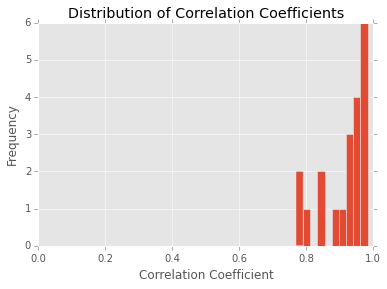

In [16]:
summary = describe(correlation)
minimum = summary[1][0]
maximum = summary[1][1]
mean = summary[2]
variance = summary[3]

print('Correlation coefficient minimum:',minimum)
print('Correlation coefficient maximum:',maximum)
print('Correlation coefficient average:',mean)
print('Correlation coefficient standard deviation:',variance**(.5))


plt.hist(correlation.values)
plt.title('Distribution of Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.xlim(0, 1.0)
plt.show()

To dig a little deeper into how well the Fitbit matches the Actigraph, the correlation coefficient for each user is plotted against minutes of MVPA. The hypothesis is that perhaps the Fitbit matches the Actigraph best when users are more sedentary (i.e., have fewer minutes of MVPA). 

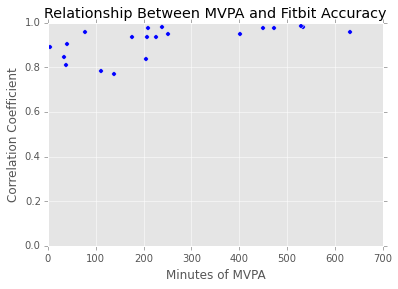

In [11]:
# Creating a DataFrame for correlation coefficients and total minutes of MVPA per user
comparison_data = pd.DataFrame(correlation)
comparison_data.columns = ['Coefficient']

by_user = accel_total.groupby(['User'])
total_mvpa = by_user.sum()['MVPA']
total_mvpa = pd.DataFrame(total_mvpa)

comparison_data['MVPA']=total_mvpa.MVPA


# Plotting correlation coefficients against total minutes of MVPA
x = comparison_data.MVPA.values
y = comparison_data.Coefficient.values

plt.scatter(x,y)
plt.title('Relationship Between MVPA and Fitbit Accuracy')
plt.xlabel('Minutes of MVPA')
plt.ylabel('Correlation Coefficient')
plt.xlim(0, 700)
plt.ylim(0, 1.0)
plt.show()

From the plot, it appears that the Fitbit is most consistently accurate when weekly minutes of MVPA are greater than 200. The only time when the correlation coefficient is lower than .80 is when weekly minutes of MVPA are less than 200. However, this might be due to factors other than Fitbit accuracy; it is possible that people who are more physically active are more in tune with tracking physical activity, making them more likely to wear both the Fitbit and the Actigraph at the same time over the study period. The people whose data have lower correlation coefficients may have forgotten to wear their Fitbit or Actigraph on study days. This can be seen on the individual user plots above; for example, user 10601 did not wear their Actigraph on May 23.

Overall, step data from Fitbit closely matches step data from research grade accelerometers when worn in free-living situations. Research done using Fitbits should take into account that Fitbit only provides step data and therefore MVPA cannot be calcuated. Additionally, Fitbits are worn on the wrist and are less accurate than accelerometers worn on the hip. However, Fitbit users would probably be more inclined to participate in research studies in which they can wear their Fitbit rather than a cumbersome accelerometer belt. All of these factors should be taken into account when deciding whether to use Fitbits in physical activity research.